In [1]:
import jax
import jax.numpy as np # try to do everything with jax...
import numpy  as onp
import pandas as pd
import pymc3  as pm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as patheffects
import dynesty as dyn
import cmocean as cmo
import glob

from tqdm  import tqdm, trange
from jax import grad, jit, vmap, jacfwd, jacrev, lax
from jax.lax import cond
from jax.config import config; config.update("jax_enable_x64", True)
from jax.experimental import ode
from functools import partial
from scipy.optimize import minimize
from scipy import integrate
from natsort import natsorted
from dynesty import plotting as dyplot

import theano
import theano.tensor as tt
import seaborn as sns
import arviz as az
import cmocean
mpl.style.use(['seaborn-poster', 'seaborn-muted'])

#betanalphas' colormap
colors = ["#DCBCBC","#C79999","#B97C7C","#A25050","#8F2727", "#7C0000","#DCBCBC20", "#8F272720","#00000060"]
color  = {i[0]:i[1] for i in zip(['light','light_highlight','mid','mid_highlight','dark','dark_highlight','light_trans','dark_trans','superfine'],colors)}
fancycolors = [mpl.colors.to_hex(c) for c in [[0.6, 0.6, 0.6],[0.7, 0.3, 1],[0.3, 0.7, 1],[0.2, 0.9, 0.9],
                                              [0.3, 1, 0.7],[0.7, 1, 0.3],[0.9, 0.9, 0.2],[1, 0.7, 0.3],[1, 0.3, 0.7],
                                              [0.9, 0.2, 0.9],[1.0, 1.0, 1.0]]]
threecolors = [mpl.colors.to_hex(c) for c in [[0.1, 0.15, 0.4],[1, 0.2, 0.25],[1.0, 0.775, 0.375]]]
fourcolors = [mpl.colors.to_hex(c) for c in [[0.9, 0.6, 0.3],[0.9, 0.4, 0.45],[0.5, 0.65, 0.75],[0.42, 0.42, 0.75]]]

def addtxt(ax, x, y, txt, fs=8, lw=3, clr='k', bclr='w', rot=0):
    """Add text to figure axis"""
    return ax.text(x, y, txt, color=clr, ha='left', transform=ax.transAxes, rotation=rot, weight='bold',
                   path_effects=[patheffects.withStroke(linewidth=lw, foreground=bclr)], fontsize=fs)
def hessian(f):
    """Returns a function which computes the Hessian of a function f
           if f(x) gives the values of the function at x, and J = hessian(f)
           J(x) gives the Hessian at x"""
    return jit(jacfwd(jacrev(f)))
def savefig(fig, name, **kargs):
    fig.savefig(f'./fig_para/{name}.png', bbox_inches='tight', **kargs)
    fig.savefig(f'./fig_para/{name}.pdf', bbox_inches='tight', **kargs)
def saveaxes(axes, name, **kargs):
    fig = axes.ravel()[0].figure
    savefig(fig, name, **kargs)

In [2]:
def dot(A,B):
    return np.einsum('...ik,...kj->...ij', A, B) # couldn't write in terms of tensordot...
def ddot(A,B):
    return np.einsum('...ij,...ji->...', A, B)

@jit
def maxwell(σ, t, κ, p):
    """return rhs of maxwell constitutive relation"""
    De = p[0]
    dσ = np.einsum('ik,jk->ij',κ,σ) + np.einsum('ik,jk->ij',σ,κ) + 1/De*(κ + np.transpose(κ)) - σ/De
    return dσ
def maxwell_trj(De, σ, κ):
    """return dσ/dt for maxwell model, given trajectory of σ values and fixed κ"""
    σκ = np.einsum('...ik,jk->...ij', σ, κ)    
    return σκ + np.transpose(σκ, (0,2,1)) + (κ + np.transpose(κ))/De - σ/De

@jit
def giesekus(σ, t, κ, p):
    """return rhs of giesekus constitutive relation"""
    De,α = p[0],p[1]
    dσ = maxwell(σ, t, κ, p[0:1]) - α*np.einsum('ik,kj->ij', σ, σ)
    return dσ
def giesekus_trj(De, α, σ, κ):
    """return dσ/dt for giesekus model, given trajectory of σ values and fixed κ"""
    return maxwell_trj(De, σ, κ) - α*dot(σ,σ)

@jit
def larson(σ, t, κ, p):
    """return rhs of larson constitutive relation"""
    De,α = p[0],p[1]
    dσ   = maxwell(σ, t, κ, p[0:1]) - α/3*(np.einsum('ij,ji', κ, σ) + np.einsum('ij,ij', κ, σ))*(De*σ + np.eye(2))
    return dσ
def larson_trj(De, α, σ, κ):
    """return dσ/dt for larson model, given trajectory of σ values and fixed κ"""
    Dσ = ddot(κ + np.transpose(κ), σ)
    return  maxwell_trj(De, σ, κ) - α/3*Dσ[...,None,None]*(De*σ + np.eye(2)[None,...])

dmaxwell  = jit(vmap(maxwell,  in_axes=(0,0,None,None)))
dgiesekus = jit(vmap(giesekus, in_axes=(0,0,None,None)))
dlarson   = jit(vmap(larson,   in_axes=(0,0,None,None)))

@partial(jit, static_argnums=(0,1))
def constitutive_solution(f, df, t, σ0, κ, p):
    """Integrate constitutive equations starting from σ0 for times t
    Use jax's default variable time-step integrator -> can't be vmapped !"""
    fargs = (κ, p)
    σ     = ode.odeint(f, σ0, t, *fargs)
    dσ    = df(σ, t, *fargs)
    return σ,dσ

def ensemble_solution(f, df, t, σ0, κ, p):
    """Integrate constitutive equations startinf from σ0 for times t for ensemble of parameter p values"""
    nts,num = len(t),len(p)
    σs  = np.zeros((num,nts,)+σ0.shape)
    dσs = np.zeros_like(σs)
    for i in trange(num):
        σ,dσ = constitutive_solution(f, df, t, σ0, κ, p[i])
        σs = jax.ops.index_update(σs, jax.ops.index[i,...], σ)
        dσs= jax.ops.index_update(dσs,jax.ops.index[i,...], dσ)
    return σs, dσs

In [3]:
params       = {'σ0':np.zeros((2,2)), 'κ':np.array([[0.0, 20.0], [0.0, 0.0]]), 'De':0.01, 'α':0.3, 'a':0.3}
params['κT'] = np.transpose(params['κ'])
params['D']  = params['κ'] + params['κT']
t            = np.linspace(0.0, 0.1, num=40)
nmicro       = 2**7        
τ            = np.arange(1,nmicro+1)*(t[1]-t[0])/nmicro

σmax,dσmax  = constitutive_solution(maxwell,  dmaxwell,  t, params['σ0'], params['κ'], [params['De']])
σgie,dσgie  = constitutive_solution(giesekus, dgiesekus, t, params['σ0'], params['κ'], [params['De'], params['α']]) 
σlar,dσlar  = constitutive_solution(larson,   dlarson,   t, params['σ0'], params['κ'], [params['De'], params['a']])

In [4]:
def noisify(key, y, rel_amplitude, abs_amplitude, nsamples):
    """Simulate measurement assuming Gaussian errors"""
    sig       = np.std(y, axis=0)
    amplitude = np.maximum(sig*rel_amplitude, abs_amplitude*np.ones_like(sig))
    print(amplitude[0,0], amplitude[0,1], amplitude[1,1])
    samples = y + amplitude*jax.random.normal(key, (nsamples,)+y.shape)
    return np.average(samples, axis=0), np.std(samples, axis=0)

key         = jax.random.PRNGKey(12345711)
dσmax_train = noisify(key, dσmax, 0.3, 0.5, 10)
key,subkey  = jax.random.split(key)
dσgie_train = noisify(key, dσgie, 0.3, 0.5, 10)
key,subkey  = jax.random.split(key)
dσlar_train = noisify(key, dσlar, 0.3, 0.5, 10)

29.368181587814455 134.29402484539435 0.5
25.644183012866634 134.3571586644335 3.913642976158923
26.215444086382185 134.14285786024467 2.9128271207091303


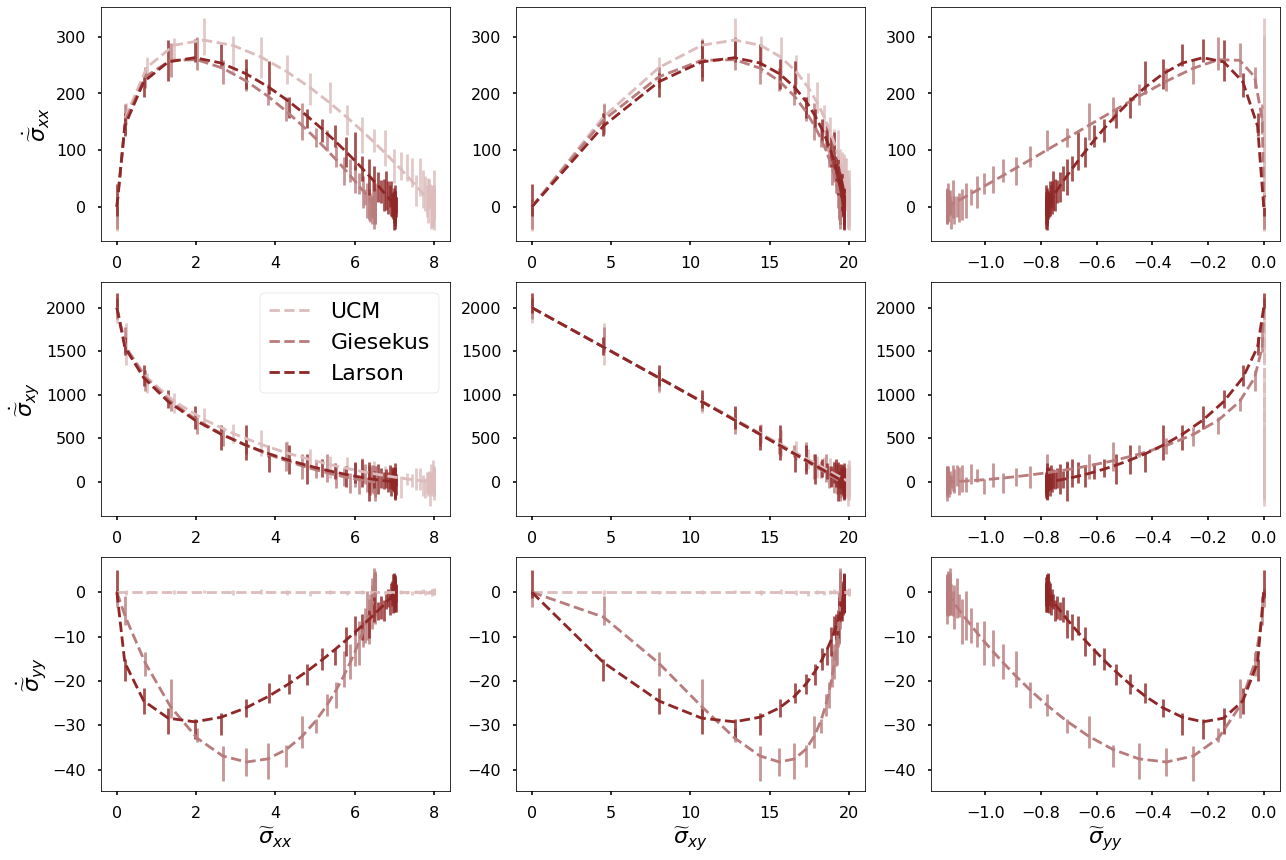

In [5]:
def plot_model(axes,σ,dσ_gold,dσ_obs,color,label,marker):
    ids = [[0,0], [0,1], [1,1]]
    for i,row in enumerate(axes):
        α,β = ids[i]
        for j,ax in enumerate(row):
            μ,ν = ids[j]
            ax.plot(σ[:,μ,ν], dσ_gold[:,α,β], color=color, label=label, ls='--')
            ax.errorbar(σ[:,μ,ν], dσ_obs[0][:,α,β], dσ_obs[1][:,α,β],color=color, marker='None', ls='None', mfc='None', mew=2, alpha=0.8)

fig, axes = plt.subplots(figsize=(18,12), ncols=3, nrows=3)
plot_model(axes, σmax, dσmax, dσmax_train, color=color['light'], label='UCM', marker='o')
plot_model(axes, σgie, dσgie, dσgie_train, color=color['mid'],  label='Giesekus', marker='p')
plot_model(axes, σlar, dσlar, dσlar_train, color=color['dark'], label='Larson', marker='s')

axes[1,0].legend(fontsize=22)
lbls = ["{xx}", "{xy}", "{yy}"]
for i,row in enumerate(axes):
    row[0].set_ylabel(f"$\dot\widetilde\sigma_{lbls[i]}$", fontsize=22)
for i,col in enumerate(axes[-1]):
    col.set_xlabel(f"$\widetilde\sigma_{lbls[i]}$", fontsize=22)
savefig(fig, 'cons_eq_noisy')

fig.tight_layout()

In [6]:
def logp_normal(ymodel, yavg, yerr):
    """Return (minus) likelihood of Gaussian distribution"""
    dy = (yavg - ymodel)/yerr
    return 0.5*(np.sum(dy**2) + len(yavg)*np.log(2*onp.pi)) + np.sum(np.log(yerr))

@jit
def logp_maxwell0(p, σdot, ϵdot, σ, κ):
    """Return (minus) posterior for Maxwell model, with Gaussian measurement error
    Args:
      p : list of model parameters
      σdot : observed values for xy component of CE
      ϵdot : observed errors for xy component of CE
      σ    : measured stress tensors
      κ    : velocity gradient tensor
    """
    De = p[0]
    σdot_model = maxwell_trj(De, σ, κ)
    lxx = logp_normal(σdot_model[:,0,0], σdot[:,0,0], ϵdot[:,0,0])
    lxy = logp_normal(σdot_model[:,0,1], σdot[:,0,1], ϵdot[:,0,1])
    lyy = logp_normal(σdot_model[:,1,1], σdot[:,1,1], ϵdot[:,1,1])
    return lxx + lxy + lyy
logp_maxwellmap = jit(vmap(logp_maxwell0,  in_axes=(0,None,None,None,None)))

def logp_maxwell(p, σdot, ϵdot, σ, κ):    
    return logp_maxwell0(np.exp(p), σdot, ϵdot, σ, κ)
dlogp_maxwell = jit(grad(logp_maxwell))
hess_maxwell  = hessian(logp_maxwell0)

@jit
def logp_giesekus0(p, σdot, ϵdot, σ, κ):
    """Return (minus) posterior for Giesekus model, assuming Gaussian measurement error"""
    De,α = p
    σdot_model = giesekus_trj(De, α, σ, κ)
    lxx = logp_normal(σdot_model[:,0,0], σdot[:,0,0], ϵdot[:,0,0])
    lxy = logp_normal(σdot_model[:,0,1], σdot[:,0,1], ϵdot[:,0,1])
    lyy = logp_normal(σdot_model[:,1,1], σdot[:,1,1], ϵdot[:,1,1])
    return lxx + lxy + lyy
logp_giesekusmap = jit(vmap(logp_giesekus0, in_axes=(0,None,None,None,None)))

def logp_giesekus(p, σdot, ϵdot, σ, κ):
    return logp_giesekus0(np.exp(p), σdot, ϵdot, σ, κ)
dlogp_giesekus = jit(grad(logp_giesekus))
hess_giesekus  = hessian(logp_giesekus0)

@jit
def logp_larson0(p, σdot, ϵdot, σ, κ):
    """Return (minus) posterior for Larson model, assuming Gaussian measurement error"""
    De,α = p
    σdot_model = larson_trj(De, α, σ, κ)
    lxx = logp_normal(σdot_model[:,0,0], σdot[:,0,0], ϵdot[:,0,0])
    lxy = logp_normal(σdot_model[:,0,1], σdot[:,0,1], ϵdot[:,0,1])
    lyy = logp_normal(σdot_model[:,1,1], σdot[:,1,1], ϵdot[:,1,1])
    return lxx + lxy + lyy
logp_larsonmap = jit(vmap(logp_larson0, in_axes=(0,None,None,None,None)))

def logp_larson(p, σdot, ϵdot, σ, κ):
    return logp_larson0(np.exp(p), σdot, ϵdot, σ, κ)
dlogp_larson = jit(grad(logp_larson))
hess_larson  = hessian(logp_larson0)

# Least-Squares Fit

In [7]:
def max_aposteriori(logp, dlogp, hess, init, σdot, ϵdot, σ, κ):
    opt = [{'x':init}]
    args= (σdot, ϵdot, σ, κ)
    opt.append(minimize(logp, opt[-1]['x'], args=args, method='Nelder-Mead'))     # simplex
    opt.append(minimize(logp, opt[-1]['x'], args=args, method='BFGS', jac=dlogp)) # gradient minimizer
    x  = np.exp(opt[-1]['x'])
    dx = np.sqrt(np.diag(np.linalg.inv(hess(x, *args))))
    print(opt[-1]['message'])
    print(f"χ2 = {opt[-1]['fun']:.4e}")
    for i,xi in enumerate(x):
        print(f"\t θ_{i} = {xi:1.4e} +/- {dx[i]:1.1e}")
    print()
    return opt[-1]

In [8]:
def output(logl, logw_dir, logw_lap, logw_int):
    base10 = 1.0/np.log(10)
    logz_dir, logz_lap, logz_int = logw_dir + logl, logw_lap + logl, logw_int + logl
    z_dir, z_lap, z_int          = np.exp(logz_dir), np.exp(logz_lap), np.exp(logz_int)
    print(f'log(L*)  = {logl:.4e}')
    print(f'log(W)   :  (direct) {logw_dir:.4e} \t (laplace) {logw_lap:.4e} \t (quadrature) {logw_int:.4e}')
    print(f'log(Z)   :           {logz_dir:.4e} \t           {logz_lap:.4e} \t              {logz_int:.4e}')
    print(f'log10(Z) :           {logz_dir*base10:.4e} \t           {logz_lap*base10:.4e} \t              {logz_int*base10:.4e}')
    print(f'Z        :           {   z_dir:.4e} \t           {   z_lap:.4e} \t              {   z_int:.4e}')    
    print()    

def logSummation(logx):
    """Function to perform logarithmic summation of array of values (also given in log)"""
    logxmax = np.max(logx)
    return logxmax + np.log(np.sum(np.exp(logx-logxmax)))

    
def ZmaxwellDirect(*args):
    print('Maxwell')
    opt   = max_aposteriori(logp_maxwell, dlogp_maxwell, hess_maxwell, np.array([-2]), *args)
    logl0 = -opt['fun']    
    θ0    = np.exp(opt['x'])
    Σ0    = np.linalg.inv(hess_maxwell(θ0, *args))

    Des      = np.linspace(1e-15, 1.0, endpoint=False, num=2e4).reshape(-1,1)
    logΔ     = np.log(Des[1][0]-Des[0][0]) - logl0
    logW_dir = logSummation(-logp_maxwellmap(Des, *args) + logΔ)

    logW_lap = 0.5*np.log(np.linalg.det(2*onp.pi*Σ0))                                     # W = np.sqrt(np.linalg.det(2*onp.pi*Σ0))    
    logW_int = 0.0 # np.log(integrate.quad(lambda De : np.exp(-logp_maxwell0([De], *args)-logl0), 0.0, 0.02)[0])

    output(logl0,logW_dir, logW_lap, logW_int)
    return {'opt':opt, 'logL':logl0, 'logW_dir':logW_dir, 'logW_lap':logW_lap, 'logW_int':logW_int}

def ZgiesekusDirect(*args):
    print('Giesekus')
    opt  = max_aposteriori(logp_giesekus, dlogp_giesekus, hess_giesekus, np.array([-2,-2]), *args)
    logl0= -opt['fun']
    θ0   = np.exp(opt['x'])
    Σ0   = np.linalg.inv(hess_giesekus(θ0, *args))
    
    #ps       = np.meshgrid(np.linspace(1e-15, 1.0, endpoint=False, num=2e4), np.linspace(0, 1.0, endpoint=False, num=5e3), indexing='ij')
    #logΔ     = np.log(ps[0][1][0]-ps[0][0][0]) + np.log(ps[1][0][1]-ps[1][0][0]) - logl0
    #ps       = np.transpose(np.array(ps)).reshape(-1,2)
    logW_dir = 0.0 #logSummation(-logp_giesekusmap(ps, *args) + logΔ)
        
    logW_lap = 0.5*np.log(np.linalg.det(2*onp.pi*Σ0))
    logW_int = 0.0 # np.log(integrate.dblquad(lambda De, α: np.exp(-logp_giesekus0([De,α], *args)-logl0), 0.0, 0.02, lambda x: 0.0, lambda x: 1.0)[0])
    
    output(logl0,logW_dir,logW_lap, logW_int)
    return {'opt':opt, 'logL':logl0, 'logW_dir':logW_dir, 'logW_lap':logW_lap, 'logW_int':logW_int}

def ZlarsonDirect(*args):
    print('Larson')
    opt  = max_aposteriori(logp_larson, dlogp_larson, hess_larson, np.array([-2,-2]), *args)
    logl0= -opt['fun']
    θ0   = np.exp(opt['x'])
    Σ0   = np.linalg.inv(hess_larson(θ0, *args))
    
    #ps       = np.meshgrid(np.linspace(1e-15, 1.0, endpoint=False, num=1e4), np.linspace(0, 1.0, endpoint=False, num=2e3), indexing='ij')
    #logΔ     = np.log(ps[0][1][0]-ps[0][0][0]) + np.log(ps[1][0][1]-ps[1][0][0]) - logl0
    #ps       = np.transpose(np.array(ps)).reshape(-1,2)
    logW_dir = 0.0 #logSummation(-logp_larsonmap(ps, *args) + logΔ)

    logW_lap = 0.5*np.log(np.linalg.det(2*onp.pi*Σ0))
    logW_int = 0.0 # np.log(integrate.dblquad(lambda De, α: np.exp(-logp_larson0([De, α], *args)-logl0), 0.0, 0.02, lambda x: 0.0, lambda x: 1.0)[0])

    
    output(logl0, logW_dir, logW_lap, logW_int)
    return {'opt':opt, 'logL':logl0, 'logW_dir':logW_dir, 'logW_lap':logW_lap, 'logW_int':logW_int}

In [9]:
def ZmaxwellNS(*args):
    print('Maxwell')
    dsampler = dyn.DynamicNestedSampler(lambda x : -logp_maxwell0(x, *args), lambda x : x, ndim=1, bound='multi', sample='unif')
    dsampler.run_nested(dlogz_init=0.001, nlive_init=500, nlive_batch=500, wt_kwargs={'pfrac': 0.0}, stop_kwargs={'pfrac': 0.0})
    return {'res':dsampler.results, 'sampler':dsampler}
def ZgiesekusNS(*args):
    print('Giesekus')
    dsampler = dyn.DynamicNestedSampler(lambda x : -logp_giesekus0(x, *args), lambda x : x, ndim=2, bound='multi', sample='unif')
    dsampler.run_nested(dlogz_init=0.001, nlive_init=500, nlive_batch=500, wt_kwargs={'pfrac':0.0}, stop_kwargs={'pfrac': 0.0})
    return {'res':dsampler.results, 'sampler':dsampler}
def ZlarsonNS(*args):
    print('Larson')
    dsampler = dyn.DynamicNestedSampler(lambda x : -logp_larson0(x, *args), lambda x : x, ndim=2, bound='multi', sample='unif')
    dsampler.run_nested(dlogz_init=0.001, nlive_init=500, nlive_batch=500, wt_kwargs={'pfrac':0.0}, stop_kwargs={'pfrac':0.0})
    return {'res':dsampler.results, 'sampler':dsampler}

## Maxwell Data

In [ ]:
logp_normal(σdot_model[:,0,0], σdot[:,0,0], ϵdot[:,0,0])

In [10]:
args     = (dσmax_train[0], dσmax_train[1], σmax, params['κ'])

In [17]:
Zmaxwell = {'maxwell' : ZmaxwellDirect(*args),               
            'giesekus': ZgiesekusDirect(*args),
            'larson'  : ZlarsonDirect(*args)}

Maxwell
Optimization terminated successfully.
χ2 = 4.0478e+02
	 θ_0 = 1.0048e-02 +/- 5.8e-05

log(L*)  = -4.0478e+02
log(W)   :  (direct) -8.8333e+00 	 (laplace) -8.8334e+00 	 (quadrature) 0.0000e+00
log(Z)   :           -4.1361e+02 	           -4.1361e+02 	              -4.0478e+02
log10(Z) :           -1.7963e+02 	           -1.7963e+02 	              -1.7579e+02
Z        :           2.3462e-180 	           2.3459e-180 	              1.6091e-176

Giesekus
Optimization terminated successfully.
χ2 = 4.0478e+02
	 θ_0 = 1.0048e-02 +/- 5.8e-05
	 θ_1 = 1.5407e-17 +/- 1.7e-04

log(L*)  = -4.0478e+02
log(W)   :  (direct) 0.0000e+00 	 (laplace) -1.6570e+01 	 (quadrature) 0.0000e+00
log(Z)   :           -4.0478e+02 	           -4.2135e+02 	              -4.0478e+02
log10(Z) :           -1.7579e+02 	           -1.8299e+02 	              -1.7579e+02
Z        :           1.6091e-176 	           1.0246e-183 	              1.6091e-176

Larson
Optimization terminated successfully.
χ2 = 4.0478e+02
	 

In [12]:
Zmaxwell_ns = {'maxwell':ZmaxwellNS(*args),
               'giesekus':ZgiesekusNS(*args),
               'larson':ZlarsonNS(*args)}

1it [00:00,  7.43it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 1 | eff(%):  0.200 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.166 | dlogz:    inf >  0.001]

Maxwell


28037it [01:51, 251.84it/s, batch: 4 | bound: 45 | nc: 1 | ncall: 124881 | eff(%): 22.451 | loglstar:   -inf < -404.779 < -405.573 | logz: -413.586 +/-  0.089 | stop:  0.895]            
1it [00:00,  8.62it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 1 | eff(%):  0.200 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.166 | dlogz:    inf >  0.001]

Giesekus


77421it [05:54, 218.24it/s, batch: 7 | bound: 195 | nc: 1 | ncall: 272918 | eff(%): 28.368 | loglstar:   -inf < -404.794 < -405.351 | logz: -422.461 +/-  0.098 | stop:  0.899]              
1it [00:00,  8.79it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 1 | eff(%):  0.200 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.166 | dlogz:    inf >  0.001]

Larson


66303it [04:55, 224.71it/s, batch: 6 | bound: 167 | nc: 1 | ncall: 256453 | eff(%): 25.854 | loglstar:   -inf < -404.794 < -406.519 | logz: -422.038 +/-  0.104 | stop:  0.972]              


In [35]:
def computez(res):
    x,y,dy = res['logvol'], res['logz'], res['logzerr']
    z      = np.exp(y)
    dz     = np.abs(z)*np.abs(dy)
    return x,y,dy,z,dz
def summarize(ns, rtag):
    logxi, logzi, dlogzi, zi, dzi = computez(ns[rtag]['res'])
    

    
    for j,key in enumerate(ns.keys()):
        logxj,logzj,dlogzj,zj,dzj = computez(ns[key]['res'])
        
        l10 = 10/np.log(10.0)
        rij = zi[-1]/zj[-1]
        Oij = l10*(logzi[-1] - logzj[-1])
        
        print(f"{rtag} / {key} : ")
        print(f"\t 10log10(Oij) = {Oij:.1e} +/- {np.sqrt(dlogzi[-1]**2 + dlogzj[-1]**2):.1e}")        
        print(f"\t Zi/Zj        = {rij:.1e} +/- {np.abs(rij)*np.sqrt((dzi[-1]/zi[-1])**2 + (dzj[-1]/zj[-1])**2):.1e}")
        print(f"\t P_i          ~ {10**(Oij/10):.2e} x P_j")
        print()
def plot(ns):
    fig, ax = plt.subplots()
    clrs = [color['light'], color['mid'], color['dark']]
    for j,key in enumerate(ns.keys()):
        logxj,logzj,dlogzj,zj,dzj = computez(ns[key]['res'])
        print(f"{key:10s} : logZ = {logzj[-1]:.4e} +/- {dlogzj[-1]:.0e} \t Z = {zj[-1]:.4e} +/- {dzj[-1]:.0e}")
        print()        
        ax.fill_between(-logxj, zj-3*dzj, zj+3*dzj, color=clrs[j], label=key, alpha=0.8)
    ax.legend()
    plt.show()

maxwell    : logZ = -4.1358e+02 +/- 8e-02 	 Z = 2.4322e-180 +/- 2e-181

giesekus   : logZ = -4.2248e+02 +/- 9e-02 	 Z = 3.3018e-184 +/- 3e-185

larson     : logZ = -4.2205e+02 +/- 1e-01 	 Z = 5.1023e-184 +/- 5e-185



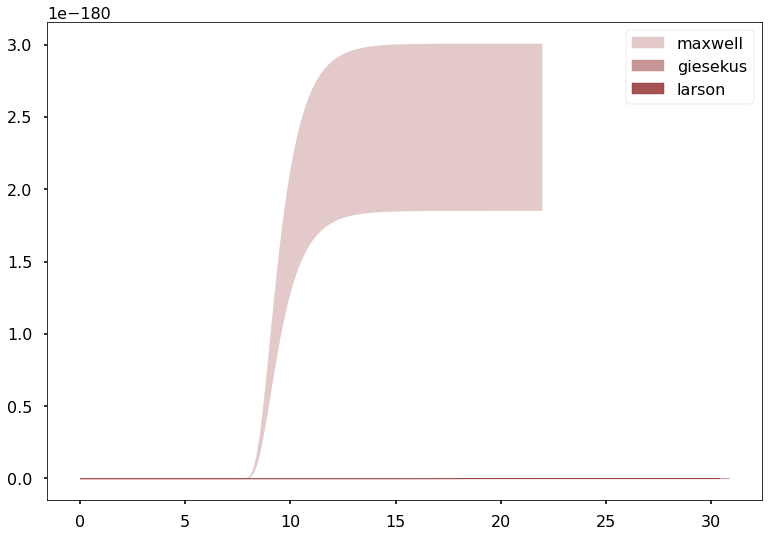

maxwell / maxwell : 
	 10log10(Oij) = 0.0e+00 +/- 1.1e-01
	 Zi/Zj        = 1.0e+00 +/- 1.1e-01
	 P_i          ~ 1.00e+00 x P_j

maxwell / giesekus : 
	 10log10(Oij) = 3.9e+01 +/- 1.2e-01
	 Zi/Zj        = 7.4e+03 +/- 8.9e+02
	 P_i          ~ 7.37e+03 x P_j

maxwell / larson : 
	 10log10(Oij) = 3.7e+01 +/- 1.2e-01
	 Zi/Zj        = 4.8e+03 +/- 5.9e+02
	 P_i          ~ 4.77e+03 x P_j



In [37]:
plot(Zmaxwell_ns)
summarize(Zmaxwell_ns, 'maxwell')

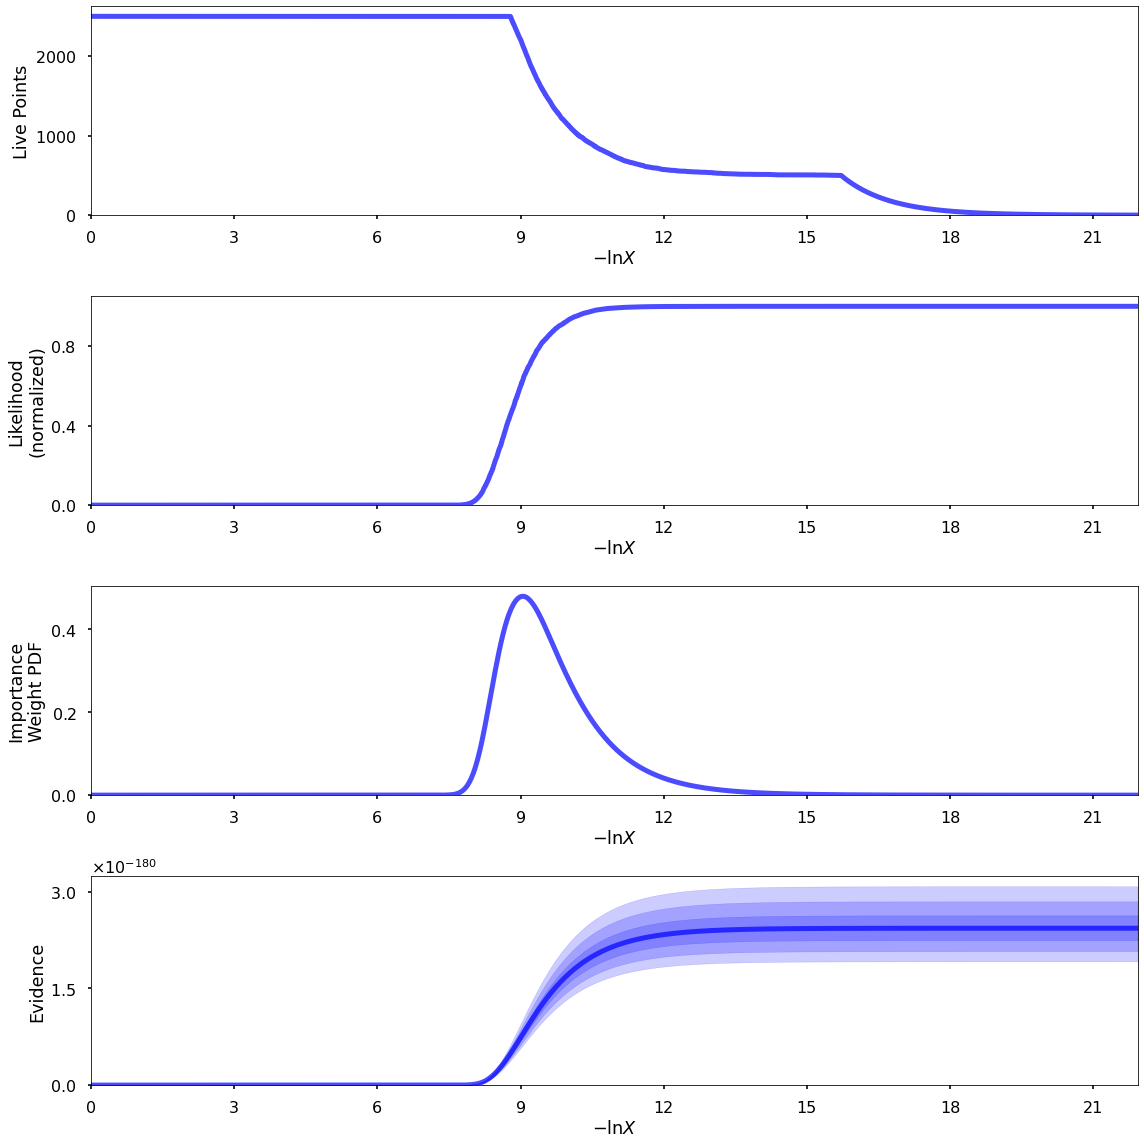

In [15]:
fig, axes = dyplot.runplot(Zmaxwell_ns['maxwell']['res'], color='blue')
fig.tight_layout()

## Giesekus Data

In [19]:
args   = (dσgie_train[0], dσgie_train[1], σgie, params['κ'])

In [ ]:
Zgiesekus = {'maxwell' : ZmaxwellDirect(*args),
             'giesekus': ZgiesekusDirect(*args),
             'larson'  : ZlarsonDirect(*args)}

In [21]:
Zgiesekus_ns = {'maxwell':ZmaxwellNS(*args),
                'giesekus':ZgiesekusNS(*args),
                'larson':ZlarsonNS(*args)}

1it [00:00,  8.44it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 1 | eff(%):  0.200 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.171 | dlogz:    inf >  0.001]

Maxwell


16428it [00:52, 310.84it/s, batch: 2 | bound: 28 | nc: 1 | ncall: 70747 | eff(%): 23.221 | loglstar:   -inf < -13675.509 < -13676.181 | logz: -13683.184 +/-  0.118 | stop:  0.909]       
1it [00:00,  8.67it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 1 | eff(%):  0.200 | loglstar:   -inf < -222649.676 <    inf | logz: -222656.586 +/-  0.166 | dlogz:    inf >  0.001]

Giesekus


49379it [03:17, 249.51it/s, batch: 5 | bound: 110 | nc: 1 | ncall: 191158 | eff(%): 25.832 | loglstar:   -inf < -481.877 < -483.412 | logz: -496.383 +/-  0.104 | stop:  0.966]            
1it [00:00,  8.17it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 1 | eff(%):  0.200 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.166 | dlogz:    inf >  0.001]

Larson


40889it [02:32, 268.37it/s, batch: 4 | bound: 88 | nc: 1 | ncall: 156599 | eff(%): 26.111 | loglstar:   -inf < -739.962 < -740.600 | logz: -754.079 +/-  0.115 | stop:  0.883]           


maxwell    : logZ = -1.3683e+04 +/- 1e-01 	 Z = 0.0000e+00 +/- 0e+00

giesekus   : logZ = -4.9642e+02 +/- 1e-01 	 Z = 2.5554e-216 +/- 2e-217

larson     : logZ = -7.5405e+02 +/- 1e-01 	 Z = 0.0000e+00 +/- 0e+00



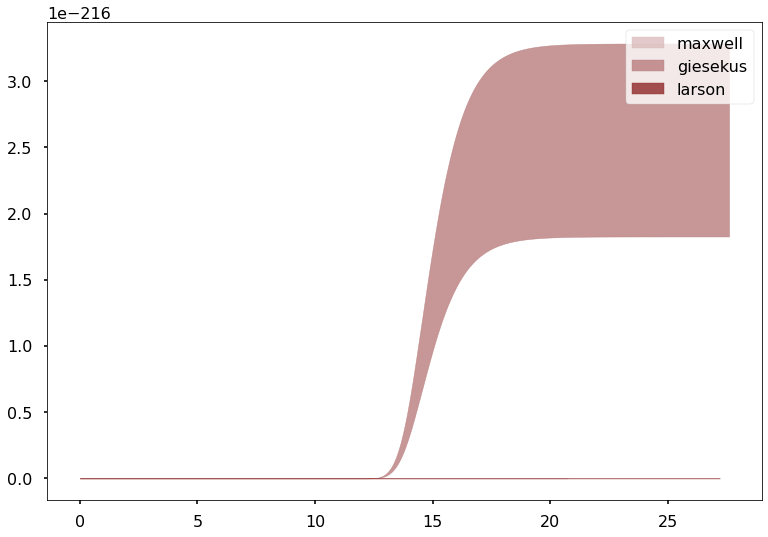

giesekus / maxwell : 
	 10log10(Oij) = 5.7e+04 +/- 1.3e-01
	 Zi/Zj        = inf +/- nan
	 P_i          ~ inf x P_j

giesekus / giesekus : 
	 10log10(Oij) = 0.0e+00 +/- 1.3e-01
	 Zi/Zj        = 1.0e+00 +/- 1.3e-01
	 P_i          ~ 1.00e+00 x P_j

giesekus / larson : 
	 10log10(Oij) = 1.1e+03 +/- 1.4e-01
	 Zi/Zj        = inf +/- nan
	 P_i          ~ 7.75e+111 x P_j



In [38]:
plot(Zgiesekus_ns)
summarize(Zgiesekus_ns, 'giesekus')

In [8]:
np.exp(-4e2)

DeviceArray(1.9151696e-174, dtype=float64)

## Larson Data

In [24]:
args   = (dσlar_train[0], dσlar_train[1], σlar, params['κ'])

In [25]:
Zlarson = {'maxwell' : ZmaxwellDirect(*args),
           'giesekus': ZgiesekusDirect(*args),
           'larson'  : ZlarsonDirect(*args)}

Maxwell
Optimization terminated successfully.
χ2 = 1.1879e+04
	 θ_0 = 1.9371e-02 +/- 1.5e-04

log(L*)  = -1.1879e+04
log(W)   :  (direct) -7.8754e+00 	 (laplace) -7.8756e+00 	 (quadrature) 0.0000e+00
log(Z)   :           -1.1887e+04 	           -1.1887e+04 	              -1.1879e+04
log10(Z) :           -5.1623e+03 	           -5.1623e+03 	              -5.1589e+03
Z        :           0.0000e+00 	           0.0000e+00 	              0.0000e+00

Giesekus
Optimization terminated successfully.
χ2 = 6.3280e+02
	 θ_0 = 1.0008e-02 +/- 5.2e-05
	 θ_1 = 2.0766e-01 +/- 1.4e-03

log(L*)  = -6.3280e+02
log(W)   :  (direct) 0.0000e+00 	 (laplace) -1.4860e+01 	 (quadrature) 0.0000e+00
log(Z)   :           -6.3280e+02 	           -6.4766e+02 	              -6.3280e+02
log10(Z) :           -2.7482e+02 	           -2.8128e+02 	              -2.7482e+02
Z        :           1.5064e-275 	           5.3016e-282 	              1.5064e-275

Larson
Optimization terminated successfully.
χ2 = 4.7410e+02
	 θ_0

In [26]:
Zlarson_ns = {'maxwell':ZmaxwellNS(*args),
              'giesekus':ZgiesekusNS(*args),
              'larson':ZlarsonNS(*args)}

1it [00:00,  8.38it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 1 | eff(%):  0.200 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.166 | dlogz:    inf >  0.001]

Maxwell


21253it [01:16, 278.53it/s, batch: 3 | bound: 34 | nc: 1 | ncall: 94655 | eff(%): 22.453 | loglstar:   -inf < -11878.732 < -11879.504 | logz: -11886.635 +/-  0.097 | stop:  0.792]        
1it [00:00,  8.73it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 1 | eff(%):  0.200 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.125 | dlogz:    inf >  0.001]

Giesekus


58022it [04:14, 227.62it/s, batch: 6 | bound: 131 | nc: 1 | ncall: 225133 | eff(%): 25.772 | loglstar:   -inf < -632.814 < -634.423 | logz: -647.626 +/-  0.096 | stop:  0.826]             
1it [00:00,  8.80it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 1 | eff(%):  0.200 | loglstar:   -inf < -490854.462 <    inf | logz: -490861.372 +/-  0.166 | dlogz:    inf >  0.001]

Larson


49182it [03:24, 240.27it/s, batch: 5 | bound: 108 | nc: 1 | ncall: 193852 | eff(%): 25.371 | loglstar:   -inf < -474.111 < -475.726 | logz: -488.580 +/-  0.104 | stop:  0.972]          


maxwell    : logZ = -1.1887e+04 +/- 8e-02 	 Z = 0.0000e+00 +/- 0e+00

giesekus   : logZ = -6.4760e+02 +/- 9e-02 	 Z = 5.6446e-282 +/- 5e-283

larson     : logZ = -4.8854e+02 +/- 9e-02 	 Z = 6.7738e-213 +/- 6e-214



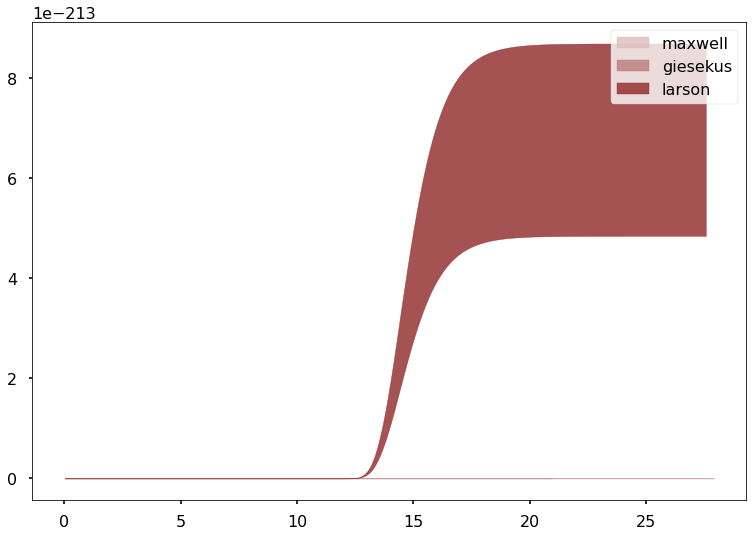

larson / maxwell : 
	 10log10(Oij) = 5.0e+04 +/- 1.3e-01
	 Zi/Zj        = inf +/- nan
	 P_i          ~ inf x P_j

larson / giesekus : 
	 10log10(Oij) = 6.9e+02 +/- 1.3e-01
	 Zi/Zj        = 1.2e+69 +/- 1.6e+68
	 P_i          ~ 1.20e+69 x P_j

larson / larson : 
	 10log10(Oij) = 0.0e+00 +/- 1.3e-01
	 Zi/Zj        = 1.0e+00 +/- 1.3e-01
	 P_i          ~ 1.00e+00 x P_j



In [39]:
plot(Zlarson_ns)
summarize(Zlarson_ns, 'larson')